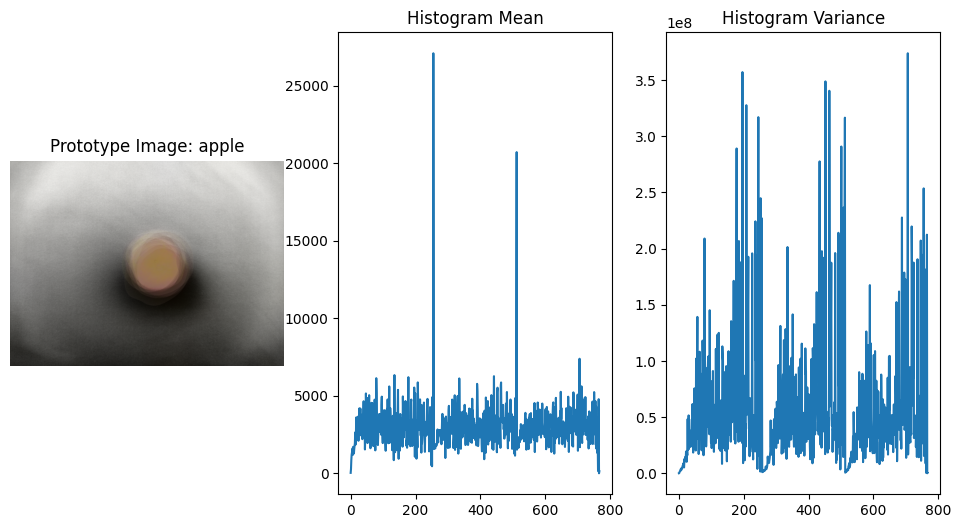

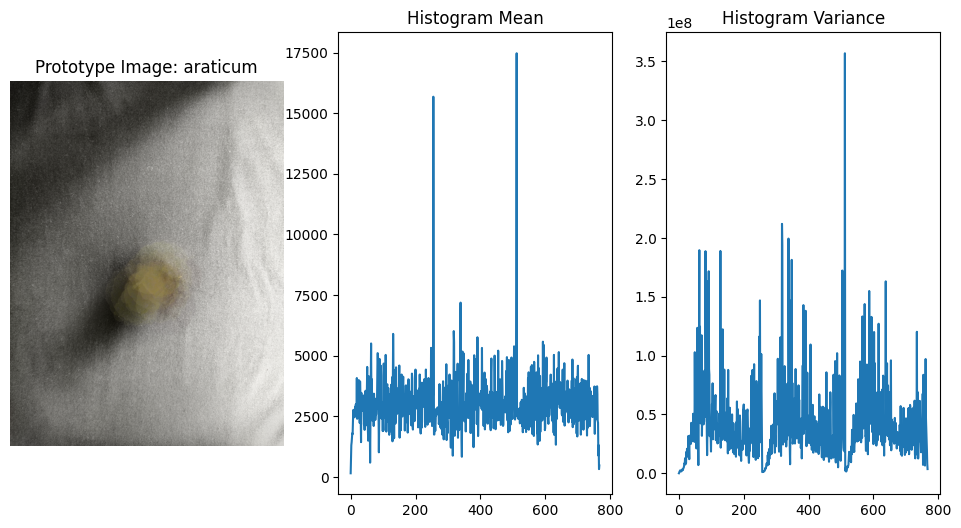

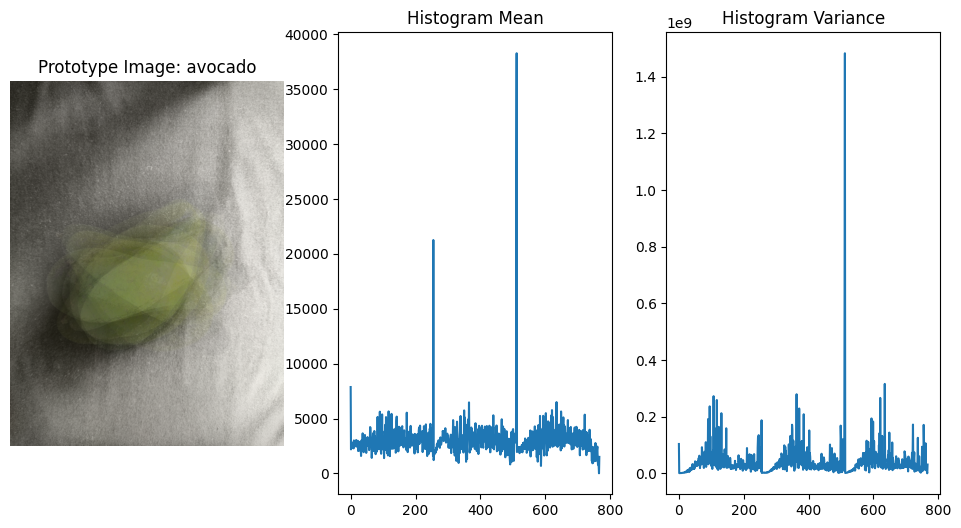

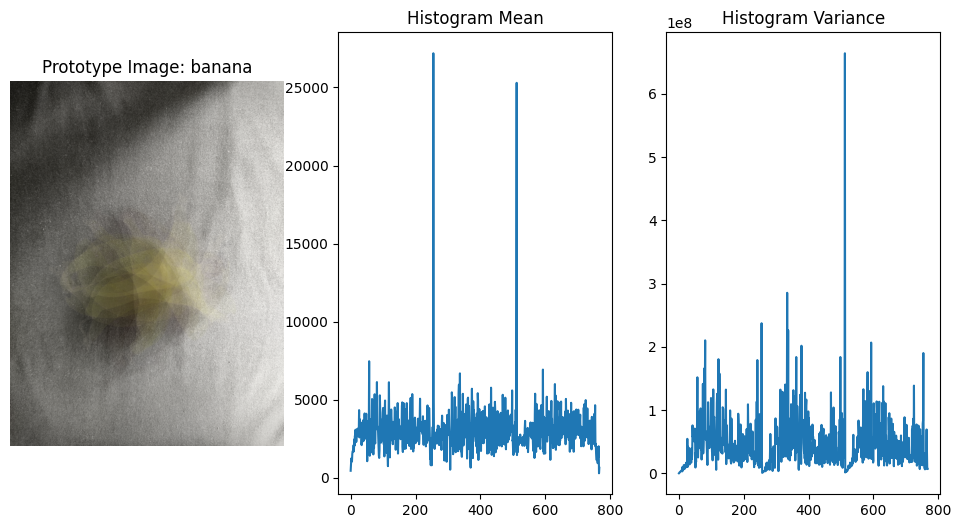

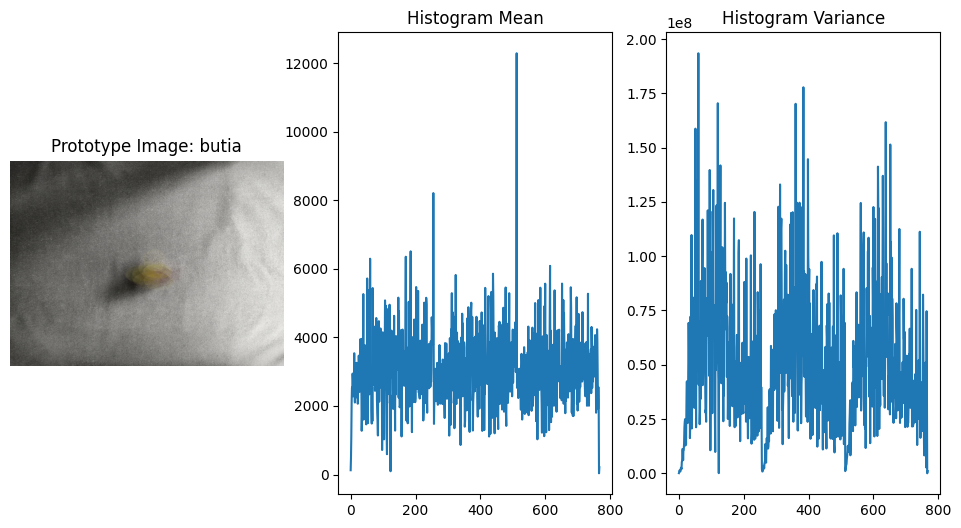

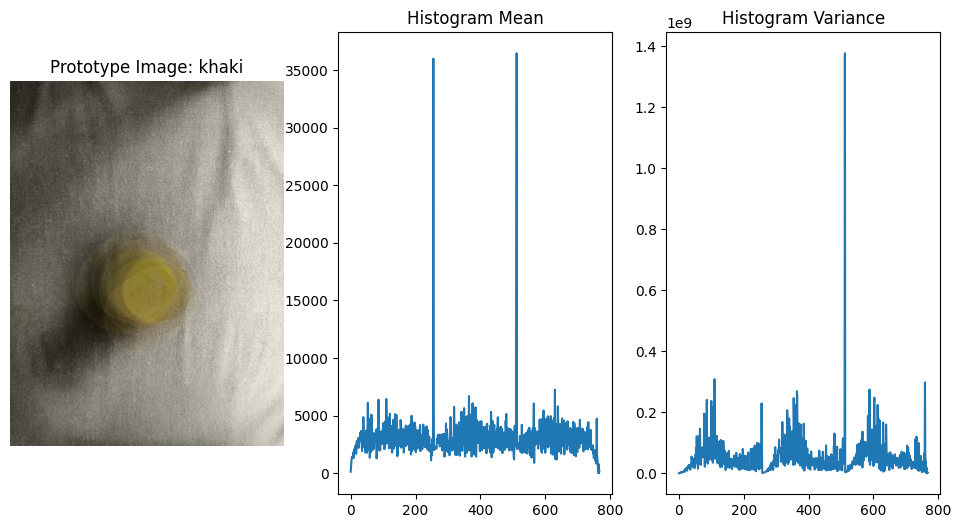

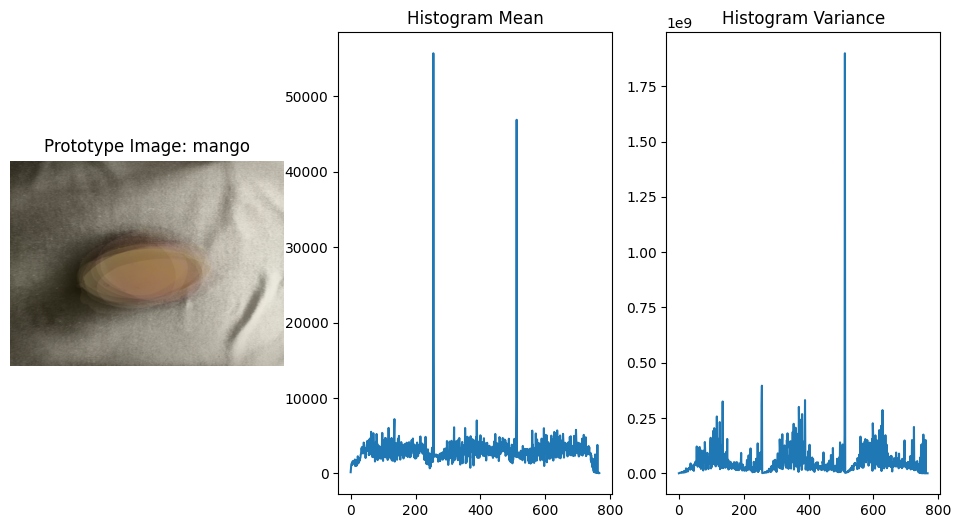

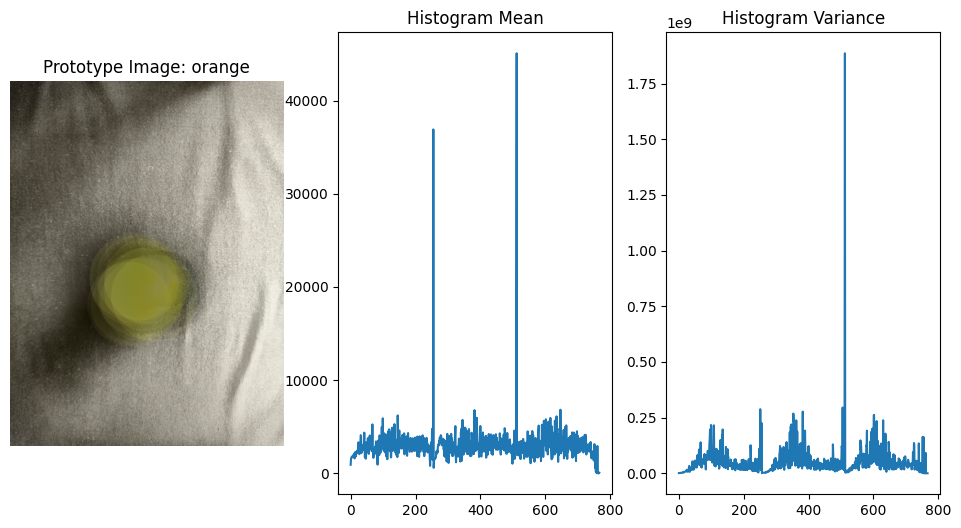

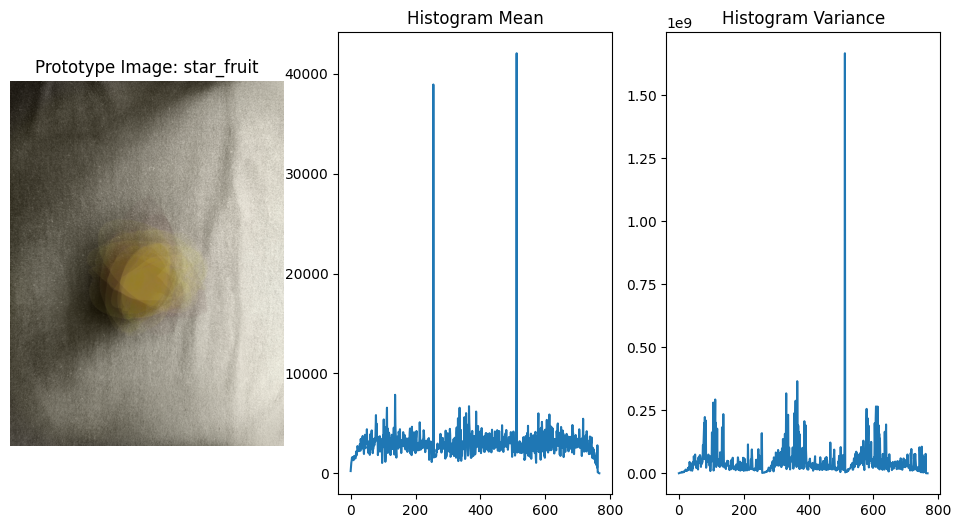

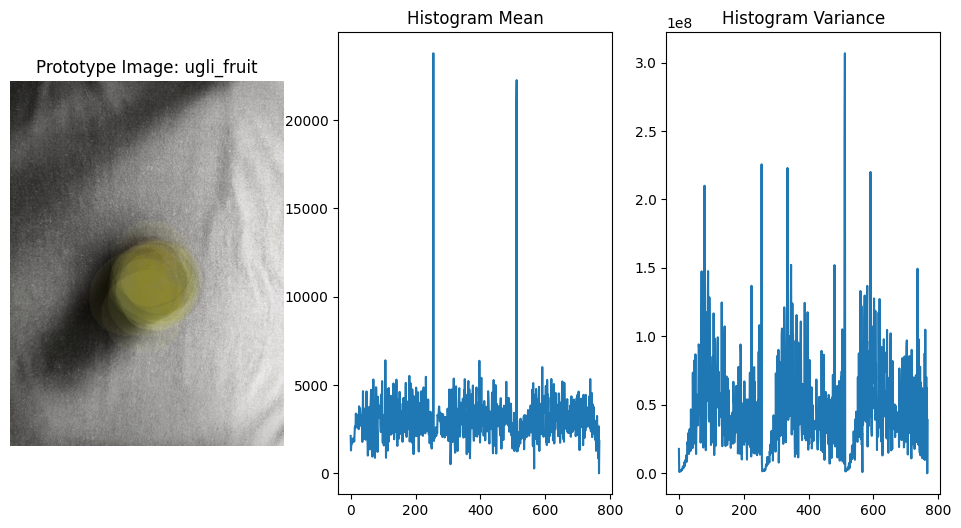

In [3]:
import gdown
import tarfile
import numpy as np
import cv2
from io import BytesIO
from skimage import io, exposure
import matplotlib.pyplot as plt
import os
import sys

def equalize_histogram(image):
    yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0])
    equalized_image = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
    return equalized_image

def calculate_prototype(images):
    # Precisamos garantir que todas as imagens tenham o mesmo tamanho
    min_shape = min([img.shape for img in images], key=lambda x: (x[0], x[1]))
    resized_images = [cv2.resize(img, (min_shape[1], min_shape[0])) for img in images]
    return np.mean(resized_images, axis=0).astype(np.uint8)

def calculate_histogram(image):
    histograms = [cv2.calcHist([image[:, :, i]], [0], None, [256], [0, 256]) for i in range(3)]
    return np.concatenate(histograms, axis=0)

def download_from_google_drive(file_id, output):
    url = f'https://drive.google.com/uc?id={file_id}'
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        try:
            sys.stdout = devnull
            sys.stderr = devnull
            gdown.download(url, output, quiet=True)
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def process_images_from_tar_gz(file_id, fruitFolders):
    output = 'file.tar.gz'
    download_from_google_drive(file_id, output)

    with open(output, 'rb') as f:
        file_like_object = BytesIO(f.read())

    with tarfile.open(fileobj=file_like_object, mode='r:gz') as tar:
        members = tar.getmembers()
        directories = sorted([m for m in members if m.isdir()], key=lambda x: x.name)
        root_directory = directories[0]
        subdirectories = sorted([m for m in directories if m.name.startswith(root_directory.name) and m != root_directory], key=lambda x: x.name)

        for subdirectory in subdirectories:
            fruit = subdirectory.name.split('/')[-1]
            if fruit not in fruitFolders:
                continue

            images = sorted([m for m in members if m.name.startswith(subdirectory.name) and m.isfile()], key=lambda x: x.name)
            equalized_images = []

            for img_member in images:
                file = tar.extractfile(img_member)
                if file:
                    image = io.imread(file)
                    if image is None:
                        continue

                    equalized_image = equalize_histogram(image)
                    equalized_images.append(equalized_image)

            if len(equalized_images) == 0:
                continue

            # Calcular o protótipo (ajustando o tamanho para o menor)
            prototype = calculate_prototype(equalized_images)

            # Calcular histogramas individualmente
            histograms = np.array([calculate_histogram(img) for img in equalized_images])
            hist_mean = np.mean(histograms, axis=0)
            hist_variance = np.var(histograms, axis=0)

            plt.figure(figsize=(12, 6))

            # Exibir imagem protótipo
            plt.subplot(1, 3, 1)
            plt.title(f'Prototype Image: {fruit}')
            plt.imshow(prototype)
            plt.axis('off')

            # Exibir média do histograma
            plt.subplot(1, 3, 2)
            plt.title('Histogram Mean')
            plt.plot(hist_mean)

            # Exibir variância do histograma
            plt.subplot(1, 3, 3)
            plt.title('Histogram Variance')
            plt.plot(hist_variance)

            plt.show()

# ID do arquivo no Google Drive
file_id = '1IEH69XRo812gpRYMPI3Ioj8anvufL_Oq'
fruitFolders = ['apple', 'araticum', 'avocado', 'banana', 'butia', 'khaki', 'mango', 'orange', 'star_fruit', 'ugli_fruit']
process_images_from_tar_gz(file_id, fruitFolders)
